In [1]:
import os
import h5py
import tqdm
import helpers
import warnings
import numpy as np 
from copy import copy
import matplotlib.pyplot as plt
from os.path import join
from scipy import signal
from copy import deepcopy
from multiprocessing import Pool
from scipy.signal import hilbert
from vms.sl_numba import intg_sl
warnings.filterwarnings("ignore")
from vms.sl import SL_sdde

In [2]:
os.makedirs("output", exist_ok=True)

In [3]:
os.makedirs("output", exist_ok=True)

def load_mat(mat_filename, key):
    with h5py.File(mat_filename, 'r') as f:
        return np.array(f[key])

# SC = load_mat("data/test_conn.mat", "test_conn")
# Dist = load_mat("data/test_dist.mat", "test_dist") / 1000.0
# np.fill_diagonal(SC, 0.0)
# SC = SC/np.max(SC)
# SC = np.abs(SC)
# assert(np.trace(SC) == 0.0)
# substitute zeros with average
# SC = np.where(SC<1e-10, SC_avg, SC)
# Dist = np.where(Dist<1e4, Dist_avg, Dist)

weights = np.loadtxt("connectivity/weights.txt")
weights = weights / np.max(weights) * 2.0
tract_lengths = np.loadtxt("connectivity/tract_lengths.txt") / 1000.0  # [m]
num_nodes = weights.shape[0]
freq = 40.0

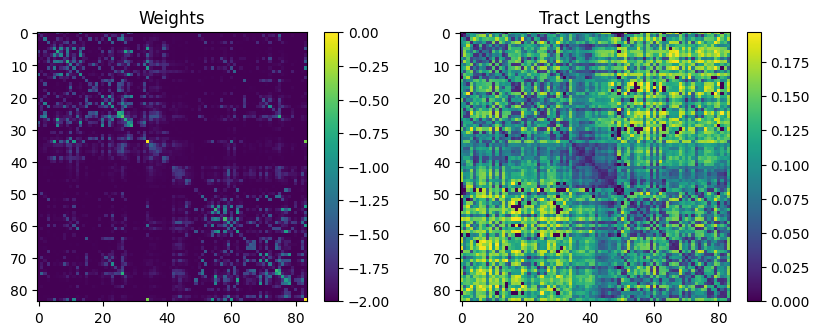

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3.5))

im = ax[0].imshow(np.log10(weights/2.0+ 0.01))
plt.colorbar(im, ax=ax[0])
ax[0].set_title("Weights")
im = ax[1].imshow(tract_lengths)
ax[1].set_title("Tract Lengths")
plt.colorbar(im, ax=ax[1]);


In [5]:
parameters = {
    "G": 1000.0,                   # global coupling strength
    "a": -5.0,                     # biforcatio parameter
    "dt": 1e-4,                    # time step [s]
    'sigma_r': 1e-4,               # noise strength
    'sigma_v': 1e-4,               # noise strength
    'omega': 2*np.pi * 40.0 * np.ones(num_nodes), 
    "noise_seed": 0,
    "velocity": 6.0,               # velocity          [m/s]

    "t_initial": 0.0,              # initial time    [s] 
    "t_transition": 5.0,           # transition time [s]
    "t_end": 15.0,               # end time        [s]   
    "method": "euler",

    "weights": weights,                # weighted connection matrix
    "distances": tract_lengths,    # distance matrix
    "record_step": 1,              # sampling every n step from mpr time series
    "data_path": "output",         # output directory
    "RECORD_TS": 0,                # true to store large time series in file
}


In [6]:
import json 
import torch
import sbi.utils as utils
import multiprocessing as mp
from vms.inference import Inference
from vms.utility import brute_sample

seed = 2
np.random.seed(seed)
torch.manual_seed(seed)

BRUTE = True
NSTEPX = 60
NSTEPY = 55
N_JOBS = 10
NUM_ENSEMBLES = 1
NUM_SIMULATIONS = (NSTEPX * NSTEPY)

prior_PAR_min = [800.0, 1.0]
prior_PAR_max = [1700.0, 20.0]

fs = 1.0/(parameters["dt"]*parameters["record_step"])
# opts = {"fmax":fmax, "fmin":fmin, "normalize": False}

prior_dist = utils.torchutils.BoxUniform(
    low=torch.as_tensor(prior_PAR_min),
    high=torch.as_tensor(prior_PAR_max))

sol = Inference()
theta = brute_sample(prior_dist,
                     NUM_SIMULATIONS,
                     NSTEPX,
                     NSTEPY,
                     NUM_ENSEMBLES)
theta.shape

torch.Size([3300, 2])

In [12]:
def wrapper(params, par=None):
    
    _par = deepcopy(params)
    control = {}
    if par is not None:
        par = np.array(par).astype(np.float64)
        control = {"G": par[0], "velocity": par[1]}
    fmin = 6.0
    fmax = 13.0

    sol = SL_sdde(_par)
    data = sol.run(par=control)
    fs = 1/(parameters['dt']*parameters['record_step'])
    
    freq, pxx = signal.welch(data['x'], fs=fs, nperseg=data['x'].shape[1]//2)
    idx = np.where((freq >= 0.0) & (freq <= 50.0))[0]
    pxx = pxx[:, idx]
    freq = freq[idx]
    pxx_avg = np.mean(pxx, axis=0)
    ind = np.argmax(pxx_avg)

    pwr = np.median(pxx, axis=0)
    ind_m = np.argmax(pwr)
    
    ## integrate under area between fmin and fmax
    idx = np.logical_and(freq >= fmin, freq <= fmax).tolist()
    area_avg = np.trapz(pxx_avg[idx], freq[idx])
    area_med = np.trapz(pwr[idx], freq[idx])

    return freq[ind_m], pwr[ind_m], area_med, freq[ind], pxx_avg[ind], area_avg

In [13]:
def batch_run(parameters, par_list):
    
    num_simulations = len(par_list)

    def update_bar(_):
        pbar.update()

    with Pool(processes=N_JOBS) as pool:
        with tqdm.tqdm(total=num_simulations) as pbar:
            async_results = [pool.apply_async(wrapper, args=(parameters,
                                                                 par_list[i]),
                                              callback=update_bar)
                             for i in range(num_simulations)]
            data = [async_result.get() for async_result in async_results]

    return data


In [14]:
par_list = []
for i in range(theta.shape[0]):
    par = [theta[i, 0].item(), theta[i, 1].item()]
    par_list.append(par)
num_simulations = len(theta)
print(len(par_list))

3300


In [17]:
# wrapper(parameters, par_list[0])

In [11]:
data = batch_run(parameters, par_list)

100%|██████████| 3300/3300 [33:56<00:00,  1.62it/s] 


In [13]:
# print(f_features(parameters, par_list[0]))

In [9]:
low = np.asarray(prior_dist.base_dist.low.tolist())
high = np.asarray(prior_dist.base_dist.high.tolist())
interval = np.abs(high - low)
x = [low[0] + i/NSTEPX * interval[0] for i in range(NSTEPX)]
y = [low[1] + j/NSTEPY * interval[1] for j in range(NSTEPY)]

In [10]:
low, high

(array([800.,   1.]), array([1700.,   20.]))

In [15]:
x = theta[:, 0].numpy()
y = theta[:, 1].numpy()
F_MED = np.array([data[i][0] for i in range(num_simulations)]).reshape((NUM_ENSEMBLES, NSTEPX, NSTEPY))
P_MED = np.array([data[i][1] for i in range(num_simulations)]).reshape((NUM_ENSEMBLES, NSTEPX, NSTEPY))
AREA_MED = np.array([data[i][2] for i in range(num_simulations)]).reshape((NUM_ENSEMBLES, NSTEPX, NSTEPY))
F_MAX = np.array([data[i][3] for i in range(num_simulations)]).reshape((NUM_ENSEMBLES, NSTEPX, NSTEPY))
P_MAX = np.array([data[i][4] for i in range(num_simulations)]).reshape((NUM_ENSEMBLES, NSTEPX, NSTEPY))
AREA_MAX = np.array([data[i][5] for i in range(num_simulations)]).reshape((NUM_ENSEMBLES, NSTEPX, NSTEPY))


In [16]:
f_avg = np.nanmean(F_MAX, axis=0)
p_avg = np.nanmean(P_MAX, axis=0)
a_avg = np.nanmean(AREA_MAX, axis=0)

f_med = np.nanmedian(F_MED, axis=0)
p_med = np.nanmedian(P_MED, axis=0)
a_med = np.nanmedian(AREA_MED, axis=0)

f_avg.shape, p_avg.shape, a_avg.shape, f_med.shape, p_med.shape, a_med.shape

((60, 55), (60, 55), (60, 55), (60, 55), (60, 55), (60, 55))

In [17]:
np.savez(join("output", "data_avg"),
         x=x,
         y=y,
         f_avg=f_avg,
         p_avg=p_avg,
         a_avg=a_avg,
         f_med=f_med,
         p_med=p_med,
         a_med=a_med)


In [11]:
data = np.load(join("output", "data_avg.npz"))
x = data['x']
y = data['y']
f_avg = data['f_avg']
p_avg = data['p_avg']
a_avg = data['a_avg']
f_med = data['f_med']
p_med = data['p_med']
a_med = data['a_med']


In [ ]:
from copy import copy

fig, ax = plt.subplots(1, 6, figsize=(20, 4), sharey=True)
helpers.plot_matrix(f_med, ax[0], extent=[low[1], high[1], low[0], high[0]], xlabel="V", ylabel="G", title="F_MED", vmax=15)
helpers.plot_matrix(np.log10(p_med), ax[1], extent=[low[1], high[1], low[0], high[0]], xlabel="V", ylabel="G", title="P_MED")
helpers.plot_matrix(np.log10(a_med), ax[2], extent=[low[1], high[1], low[0], high[0]], xlabel="V", ylabel="G", title="AREA_MED")
helpers.plot_matrix(f_avg, ax[3], extent=[low[1], high[1], low[0], high[0]], xlabel="V", ylabel="G", title="F_MAX", vmax=50)
helpers.plot_matrix(np.log10(p_avg), ax[4], extent=[low[1], high[1], low[0], high[0]], xlabel="V", ylabel="G", title="P_MAX")
helpers.plot_matrix(np.log10(a_avg) , ax[5], extent=[low[1], high[1], low[0], high[0]], xlabel="V", ylabel="G", title="AREA_AVG")
plt.tight_layout()
plt.savefig(join("output/fig.png"), dpi=300)


In [16]:
low = np.array([800., 0.5])
high = np.array([1700.0, 20.0])

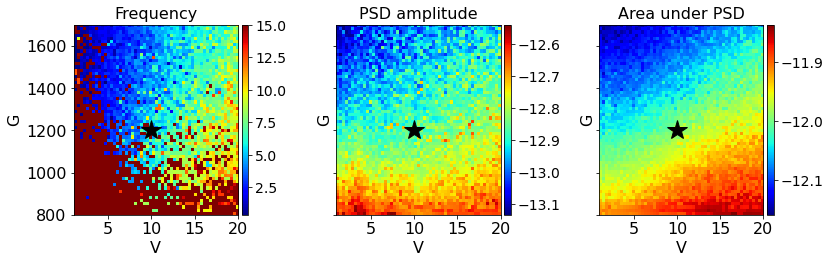

In [13]:
from copy import copy
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
helpers.plot_matrix(f_med, ax[0], extent=[low[1], high[1], low[0], high[0]], xlabel="V", ylabel="G", title="Frequency", vmax=15)
helpers.plot_matrix(np.log10(p_med), ax[1], extent=[low[1], high[1], low[0], high[0]], xlabel="V", ylabel="G", title="PSD amplitude")
helpers.plot_matrix(np.log10(a_med), ax[2], extent=[low[1], high[1], low[0], high[0]], xlabel="V", ylabel="G", title="Area under PSD")
for i in range(3):
    ax[i].plot([10], [1200], marker="*", ms=20, color='k')
    ax[i].tick_params(labelsize=16)

for i in range(3):
    ax[i].set_xticks([5, 10, 15, 20])
plt.tight_layout()


plt.savefig(join("output/fig.png"), dpi=600)
plt.savefig(join("output/fig.svg"), dpi=600)
plt.savefig(join("output/fig.tiff"), dpi=600)
